<a href="https://colab.research.google.com/github/FranBasili/22.45-Redes-Neuronales-TP2/blob/main/TP2_Segmentaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from PIL import Image
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose

from google.colab import drive

# Preprocesamiento de datos

## Carga de datos

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip drive/MyDrive/PhC-C2DH-U373.zip

Archive:  drive/MyDrive/PhC-C2DH-U373.zip
replace PhC-C2DH-U373/01/t000.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Generación Train y Validation

Generamos el dataset de train y validación que contendrán tanto las imágenes como sus máscaras asociadas.

In [ ]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [ ]:
train_images = list()
train_masks = list()

for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

## Normalización

Aplicamos una normalización a las imagenes y "cuantificamos" las máscaras.

In [ ]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

## Exploración imagenes

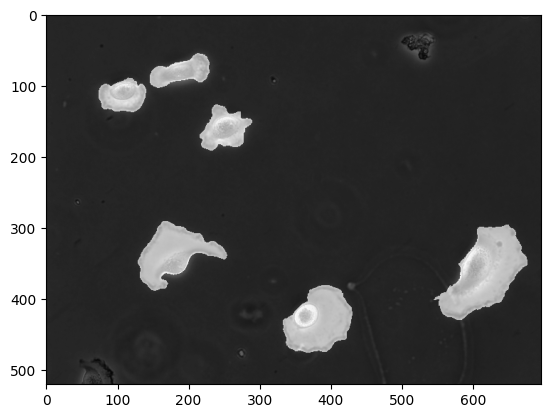

In [ ]:
idx = 80
plt.imshow(train_images[idx], cmap="gray")
plt.imshow(train_masks[idx],  cmap="gray", alpha=0.6)
plt.show()

## Restructuracion de datos

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que de descompondrán durante el entrenamiento.

In [ ]:
x_train = np.stack((train_images, train_masks), axis=-1)  #Concatenamos cada imagen con su máscara.
x_val = np.stack((val_images, val_masks), axis=-1)

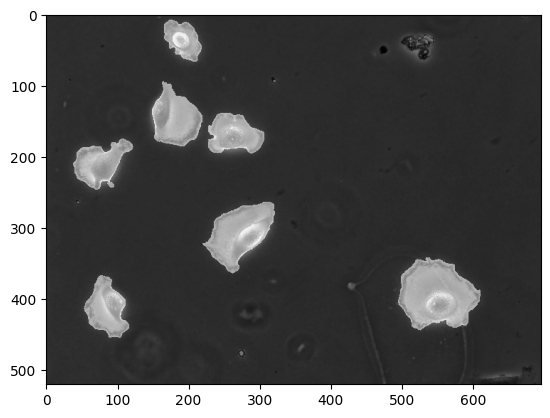

In [ ]:
#Finalmente cada dataset estara dado por:
# dataset[imagen, pixelX, pixelY, imagen o máscara]

# Ejemplo de la estructura
plt.imshow(x_train[0,:,:,0], cmap="gray")
plt.imshow(x_train[0,:,:,1], cmap="gray", alpha = 0.5)

# Definición de Metricas

Definiremos la función de costo **loss dice** como
${loss}_{dice}=\frac{predict \cap real}{predict \cup real}$ y la metrica ${coef}_{dice}=1-{loss}_{dice}$ que nos ayudará a cuantificar la similitud pixel a pixel entre la máscara predecida y la máscara real.

Notese que para considerar el caso en que las mascaras sean todos 0's se agregaro el termino $smooth<<1$ a numerador y denominador.  


In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Definicion de callbacks del modelo

In [ ]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val, dice=True):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = dice


    def call(self, inputs):       # Predicción de la máscara
        return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):
        # GradientTape is a context manager that records every operation
        with tf.GradientTape() as tape:
            # We variate training dataset each epoch
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # Preprocess the images
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)
        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        mask_out = self.red_segmentacion(data[:,:,:,:1]) # Prediction

        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out)
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out)

        return loss

# Redes generadoras de "nuevas" imagenes

Aplicamos flippeos, rotaciones, zoom y traslaciones a las imagenes originales con el objetivo de agrandar el tamaño del dataset de train.

Por su parte, para generar el dataset de validación tomamos solamente la parte central de las imagenes.

In [ ]:
# Red que genera las variaciones en las imagenes
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

# Red que genera el dataset de Validación
def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

## Ejemplo

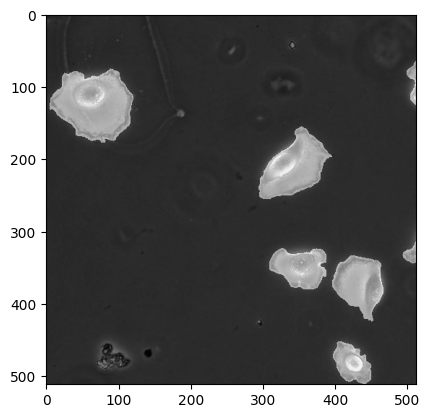

In [ ]:
preproc = get_preproc()

#Testeo del data Augmentation
aux_elem = preproc(x_train[0])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.5)

# Modelo Atrous

Será un modelo mínimo y rápido de implementar que usaremos como punto de partida para analizar si los modelos siguientes (que serán más complejos) vale la pena desarrollarnos. En caso de que el coste computacional no lo valga, optaremos por este modelo simplificado y "economico" computacionalmente hablando.

## Estructura

In [ ]:
def get_red_seg(filters=16, kernel_size=10):
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])

get_red_seg().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-trai

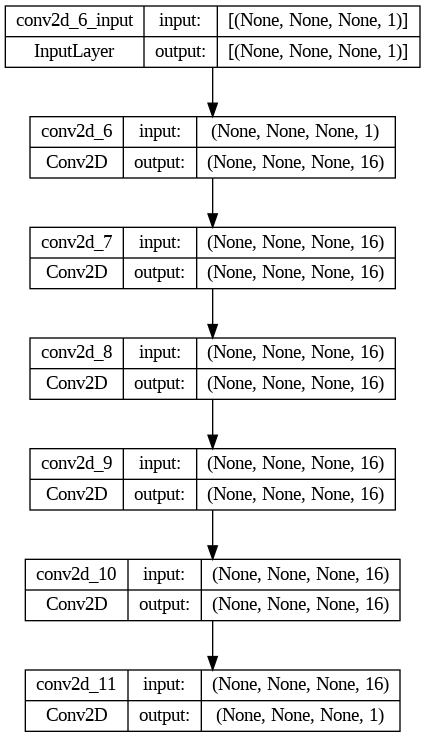

In [ ]:
keras.utils.plot_model(get_red_seg(), "atrous.png", show_shapes=True)

## Compilación y fitteo
Con las funciones y estructuras definidas, implementamos nuestro modelo al cual entrenamos. Se dejaron correr numerosas epochs con una callback de early stopping para frenar cuando la loss de validación deje de disminuir.

In [ ]:
early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10)

### Loss = Binary cross entropy

In [ ]:
red_atrous_bce=get_red_seg()

model_atrous_bce = SegmentationModel(get_preproc(), red_atrous_bce, get_preproc_val(), dice=False)
model_atrous_bce.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

model_atrous_bce.fit(np.vstack([x_train, x_val]), batch_size=8, epochs=100, validation_split = 0.7, callbacks = early_cb, verbose = 1)
model_atrous_bce.save_weights('atrous_bce.h5')
print("Caso Binary Cross Entropy")

Epoch 1/100
9/9 [==============================] - 60s 3s/step - loss: 0.6391 - val_loss: 0.4625
Epoch 2/100
9/9 [==============================] - 7s 858ms/step - loss: 0.3968 - val_loss: 0.2333
Epoch 3/100
9/9 [==============================] - 7s 786ms/step - loss: 0.3540 - val_loss: 0.2767
Epoch 4/100
9/9 [==============================] - 7s 781ms/step - loss: 0.3396 - val_loss: 0.2272
Epoch 5/100
9/9 [==============================] - 7s 782ms/step - loss: 0.3295 - val_loss: 0.2371
Epoch 6/100
9/9 [==============================] - 7s 782ms/step - loss: 0.3216 - val_loss: 0.2281
Epoch 7/100
9/9 [==============================] - 7s 782ms/step - loss: 0.3180 - val_loss: 0.2252
Epoch 8/100
9/9 [==============================] - 7s 779ms/step - loss: 0.3155 - val_loss: 0.2264
Epoch 9/100
9/9 [==============================] - 7s 787ms/step - loss: 0.3148 - val_loss: 0.2256
Epoch 10/100
9/9 [==============================] - 7s 789ms/step - loss: 0.3076 - val_loss: 0.2240
Epoch 11/10

### Loss = Dice Loss

In [ ]:
red_atrous_dice=get_red_seg()
model_atrous_dice = SegmentationModel(get_preproc(), red_atrous_dice, get_preproc_val(), dice=True)
model_atrous_dice.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

model_atrous_dice.fit(np.vstack([x_train, x_val]), batch_size=8, epochs=200, validation_split = 0.7, callbacks= early_cb, verbose = 1)
model_atrous_dice.save_weights('atrous_dice.h5')
print("Caso Dice Loss")

Epoch 1/200
9/9 [==============================] - 12s 1s/step - loss: 0.8431 - val_loss: 0.9071
Epoch 2/200
9/9 [==============================] - 7s 787ms/step - loss: 0.8325 - val_loss: 0.9029
Epoch 3/200
9/9 [==============================] - 7s 789ms/step - loss: 0.8270 - val_loss: 0.9028
Epoch 4/200
9/9 [==============================] - 7s 810ms/step - loss: 0.8326 - val_loss: 0.9009
Epoch 5/200
9/9 [==============================] - 7s 803ms/step - loss: 0.8243 - val_loss: 0.8977
Epoch 6/200
9/9 [==============================] - 7s 800ms/step - loss: 0.8132 - val_loss: 0.8939
Epoch 7/200
9/9 [==============================] - 7s 790ms/step - loss: 0.8037 - val_loss: 0.8942
Epoch 8/200
9/9 [==============================] - 7s 792ms/step - loss: 0.8119 - val_loss: 0.8896
Epoch 9/200
9/9 [==============================] - 7s 781ms/step - loss: 0.8064 - val_loss: 0.8953
Epoch 10/200
9/9 [==============================] - 7s 782ms/step - loss: 0.8163 - val_loss: 0.8958
Epoch 11/20

## Testing del modelo

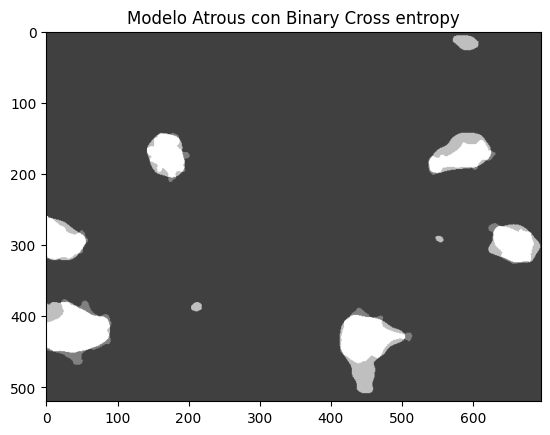

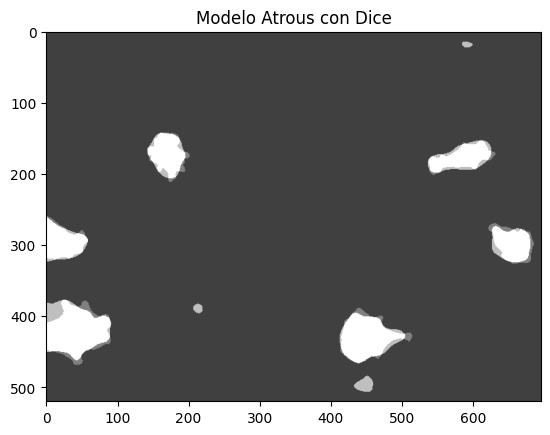

In [ ]:
plt.title("Modelo Atrous con Binary Cross entropy")
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
pred = red_atrous_bce(x_val[0:1,:,:,0])
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

plt.title("Modelo Atrous con Dice")
plt.imshow(x_val[0,:,:,1], cmap="gray", alpha=0.5)
pred = red_atrous_dice(x_val[0:1,:,:,0])
plt.imshow(pred[0,:,:,0]>0.5, cmap="gray", alpha=0.5)
plt.show()

En ambos casos el resultado obtenido es considerablemente bueno. Siendo un tanto más minucioso, trajo mejores resultados el uso de la dice loss ante la binary cross entropy.

#Modelo U-NET

## Estructuras

In [ ]:
img_shape = (512, 512, 1)

# Bloque Convolucional:
# m: entrada
# dim: cantidad de filtros
# acti: función de activación
# bn: batch_normalization
# do: dropOut Rate
# res: residual enable
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n


# Bloque por nivel:
# m: entrada
# dim: cantidad de filtros
# depth: cantidad de niveles del bloque
# inc: incremento del kernel size por nivel
# acti: función de activación
# do: dropOut Rate
# bn: batch_normalization
# mp: max pooling enable
# up: upsampling enable
# res: residual enable
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
	  # Elegimos entre reducir dimensionalidad con maxpooling u otra convolucional
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)

		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)

		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)

		# Hacemos la conexión residual y lo mergeamos antes de una capa de salida
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)

	else:
		m = conv_block(m, dim, acti, bn, res, do)

	return m

#Estructura general de la unet con todos los parametros configurables
def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o) # Capa salida final
	return Model(inputs=i, outputs=o)

In [ ]:
red_unet = UNet(img_shape, start_ch = 16, dropout = False, residual = True)
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

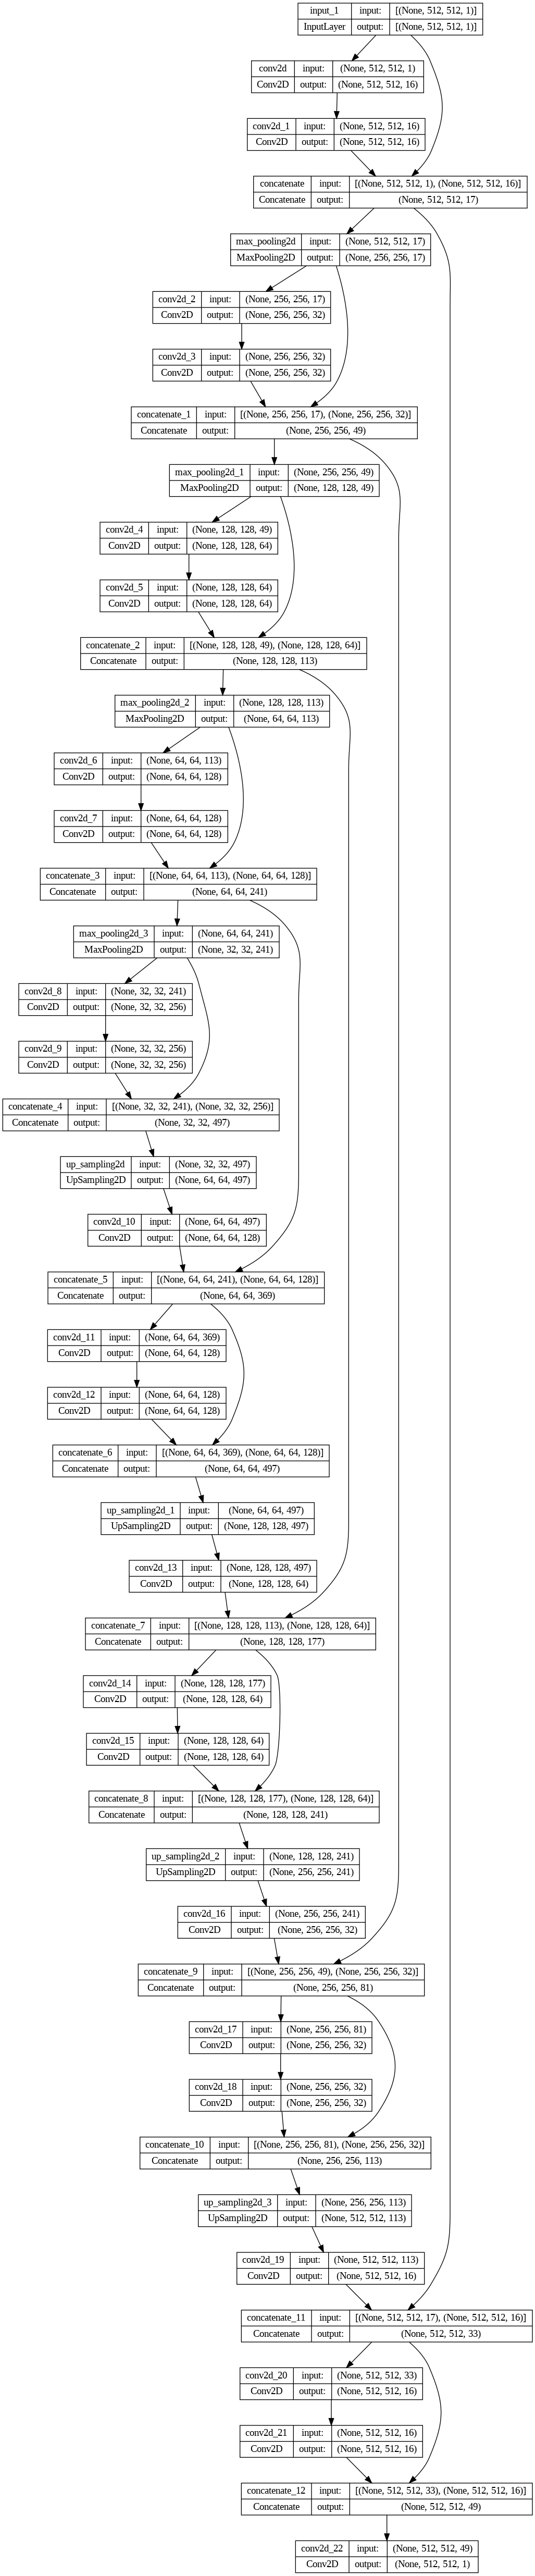

In [ ]:
keras.utils.plot_model(red_unet, "model_unet.png", show_shapes=True)

## Compilacion y fitteo

Se utilizó como metrica de loss la del tipo Dice que fue la que se consideró más acorde. En base a ella se compararan los distintos modelos.

In [ ]:
early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10)

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(img_shape, start_ch = 16, dropout = False, residual = True)

model_unet = SegmentationModel(preproc_unet, red_unet, preproc_unet_val)
model_unet.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
history_unet_orig = model_unet.fit(np.vstack([x_train, x_val]), batch_size = 8,
                         epochs=200, validation_split = 0.5,
                         callbacks= early_cb, verbose = 1)

model_unet.save_weights('unet_original.h5')

Epoch 1/200
15/15 [==============================] - 52s 1s/step - loss: 0.8417 - val_loss: 0.9306
Epoch 2/200
15/15 [==============================] - 11s 776ms/step - loss: 0.8305 - val_loss: 0.9290
Epoch 3/200
15/15 [==============================] - 12s 783ms/step - loss: 0.8282 - val_loss: 0.9263
Epoch 4/200
15/15 [==============================] - 12s 785ms/step - loss: 0.8132 - val_loss: 0.9014
Epoch 5/200
15/15 [==============================] - 12s 794ms/step - loss: 0.7474 - val_loss: 0.8693
Epoch 6/200
15/15 [==============================] - 12s 803ms/step - loss: 0.5513 - val_loss: 0.4400
Epoch 7/200
15/15 [==============================] - 12s 812ms/step - loss: 0.3107 - val_loss: 0.3702
Epoch 8/200
15/15 [==============================] - 12s 824ms/step - loss: 0.2491 - val_loss: 0.3363
Epoch 9/200
15/15 [==============================] - 12s 830ms/step - loss: 0.2338 - val_loss: 0.2704
Epoch 10/200
15/15 [==============================] - 15s 1s/step - loss: 0.1942 - va

## Testing del modelo

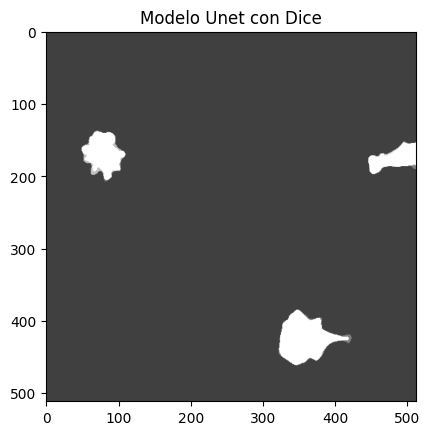

In [ ]:
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])

plt.title("Modelo Unet con Dice")
plt.imshow(aux[0,:,:,1], cmap="gray", alpha=0.5)
plt.imshow(pred[0,:,:,0]>0.7, cmap="gray", alpha=0.5)
plt.show()

Finalmente el resultado obtenido con la U-Net puede ser considerado como satisfactorio ya que las máscaras (original y predecida) resultan ser altamente similares. Comparandolo con las redes nueronales anteriores, puede verse una mejora considerable en el desempeño de las predicciones.

# Mejoras



In [ ]:
early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10)

## Eliminación de la conexión residual de la U-NET

Con el objetivo de verificar de que dicha conexión sea realmente beneficiosa, buscamos eliminarla y comparar el desempeño de ambas en igualdad de condiciones.

In [ ]:
red_unet_v2 = UNet(img_shape, start_ch = 16, dropout = False, residual = False)
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()


model_unet_v2 = SegmentationModel(preproc_unet, red_unet_v2, preproc_unet_val)
model_unet_v2.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

In [ ]:
history = model_unet_v2.fit(np.vstack([x_train, x_val]), batch_size = 8,
                         epochs=200, callbacks=early_cb,
                         validation_split = 0.5, verbose = 1)

Epoch 1/200
15/15 [==============================] - 40s 862ms/step - loss: 0.8462 - val_loss: 0.9339
Epoch 2/200
15/15 [==============================] - 6s 396ms/step - loss: 0.8435 - val_loss: 0.9334
Epoch 3/200
15/15 [==============================] - 6s 400ms/step - loss: 0.8431 - val_loss: 0.9314
Epoch 4/200
15/15 [==============================] - 6s 397ms/step - loss: 0.8287 - val_loss: 0.9107
Epoch 5/200
15/15 [==============================] - 7s 495ms/step - loss: 0.7559 - val_loss: 0.8805
Epoch 6/200
15/15 [==============================] - 6s 400ms/step - loss: 0.7336 - val_loss: 0.8710
Epoch 7/200
15/15 [==============================] - 6s 408ms/step - loss: 0.6310 - val_loss: 0.4766
Epoch 8/200
15/15 [==============================] - 6s 405ms/step - loss: 0.3383 - val_loss: 0.3196
Epoch 9/200
15/15 [==============================] - 7s 499ms/step - loss: 0.2225 - val_loss: 0.4335
Epoch 10/200
15/15 [==============================] - 6s 420ms/step - loss: 0.2291 - val_l

Como podemos ver la conexión residual sí permite mejorar el desempeño de la red en donde para la red que SI tiene conexión resiudal logramos una loss de $0.088$ mientras para la que no la tiene logramos una loss de $0.1$.

Si bien puede parecer una diferencia pequeña en el desempeño, es de considerar que la misma se obtuvo solamente con el agregado de la conexión residual que no agrega demasiada complejidad a la red.

En resumen, en las redes U-NET la conexión residual en un mismo  nivel permite una mejora real sin mucha complejidad adicional.

## Variación de las imagenes de entrenamiento
Hacemos que las imágenes varíen mucho más durante el entrenamiento, brindandole a la red la oportunidad de conocer patrones nuevos.

In [ ]:
def get_preproc_var():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        tf.keras.layers.RandomRotation((0,1)),
        tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

In [ ]:
preproc_unet_var= get_preproc_var()
preproc_unet_val= get_preproc_val()
red_unet_var = UNet(img_shape, start_ch = 16, dropout = False, residual = True)

model_unet_var = SegmentationModel(preproc_unet, red_unet_var, preproc_unet_val)
model_unet_var.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

history_unet_var = model_unet_var.fit(np.vstack([x_train, x_val]),
                         batch_size = 8, epochs=500, validation_split = 0.5,
                         callbacks= early_cb, verbose = 1)

model_unet_var.save_weights('unet_var.h5')

Epoch 1/500
15/15 [==============================] - 22s 888ms/step - loss: 0.8476 - val_loss: 0.9339
Epoch 2/500
15/15 [==============================] - 12s 809ms/step - loss: 0.8416 - val_loss: 0.9337
Epoch 3/500
15/15 [==============================] - 15s 997ms/step - loss: 0.8437 - val_loss: 0.9332
Epoch 4/500
15/15 [==============================] - 12s 828ms/step - loss: 0.8468 - val_loss: 0.9281
Epoch 5/500
15/15 [==============================] - 12s 836ms/step - loss: 0.8316 - val_loss: 0.9172
Epoch 6/500
15/15 [==============================] - 12s 839ms/step - loss: 0.7728 - val_loss: 0.8889
Epoch 7/500
15/15 [==============================] - 15s 1s/step - loss: 0.6611 - val_loss: 0.4972
Epoch 8/500
15/15 [==============================] - 12s 829ms/step - loss: 0.4898 - val_loss: 0.5556
Epoch 9/500
15/15 [==============================] - 12s 830ms/step - loss: 0.3928 - val_loss: 0.4079
Epoch 10/500
15/15 [==============================] - 15s 1s/step - loss: 0.3678 - va

**Podemos ver en este caso que variar de forma indiscriminada y sin un criterio lógico lás imagenes de entrenamiento puede no resultar tan beneficioso**. Esto sucede debido a que no sabemos si realmente estas imagenes con "perturbaciones" aportan información cierta a nuestro abanico real de posibles entradas. Analizando más en detalle este caso particular, vemos que las imagenes de validación no son croppeadas ni rotadas por lo que el hecho de aplicar estas transformaciones para realizar data augmentation tiene sentido que genere una caída en el desempeño de la red.

En conclusión, es útil aplicar tranformaciones al dataset de entrenamiento siempre y cuando los resultados de esta transformaciones también puedan pertenecer a nuestro problema a resolver.   

## Conv2DTranspose en vez de Upsampling

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet_trans = UNet(img_shape, start_ch = 16, dropout = False,
                      upconv = False, residual = True)

model_unet_trans = SegmentationModel(preproc_unet, red_unet_trans, preproc_unet_val)
model_unet_trans.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

history_unet_trans = model_unet_trans.fit(np.vstack([x_train, x_val]),
                         batch_size = 8, epochs=500, validation_split = 0.5,
                         callbacks= early_cb, verbose = 1)

model_unet_trans.save_weights('unet__trans.h5')

Epoch 1/500
15/15 [==============================] - 21s 718ms/step - loss: 0.8432 - val_loss: 0.9335
Epoch 2/500
15/15 [==============================] - 7s 480ms/step - loss: 0.8445 - val_loss: 0.9332
Epoch 3/500
15/15 [==============================] - 7s 485ms/step - loss: 0.8402 - val_loss: 0.9310
Epoch 4/500
15/15 [==============================] - 8s 556ms/step - loss: 0.8326 - val_loss: 0.9302
Epoch 5/500
15/15 [==============================] - 7s 486ms/step - loss: 0.8278 - val_loss: 0.9291
Epoch 6/500
15/15 [==============================] - 7s 481ms/step - loss: 0.8242 - val_loss: 0.9263
Epoch 7/500
15/15 [==============================] - 8s 548ms/step - loss: 0.8095 - val_loss: 0.9005
Epoch 8/500
15/15 [==============================] - 7s 474ms/step - loss: 0.7646 - val_loss: 0.8924
Epoch 9/500
15/15 [==============================] - 8s 544ms/step - loss: 0.7538 - val_loss: 0.8879
Epoch 10/500
15/15 [==============================] - 7s 470ms/step - loss: 0.7411 - val_l

Finalmente la variación entre usar Upsampling y Conv2DTransponsed no fue significativa en este caso. Posiblemente con el entrenamiento la red compense esta diferencia en la elección de tipo de layers en las capas convolucionales y de max pooling siguientes.

## Utilización de ReduceOnPlateu()

In [ ]:
plateu_cb= tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    min_delta=1e-3,
    patience=4)

early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=1e-3, patience=10)

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet_v3 = UNet(img_shape, start_ch = 16, dropout = False, residual = True)

model_unet_v3 = SegmentationModel(preproc_unet, red_unet_v3, preproc_unet_val)
model_unet_v3.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

history_unet_v3 = model_unet_v3.fit(np.vstack([x_train, x_val]),
                         batch_size = 8, epochs=500, validation_split = 0.5,
                         callbacks= [early_cb, plateu_cb], verbose = 1)

model_unet_v3.save_weights('unet_v3.h5')

Epoch 1/500
15/15 [==============================] - 22s 891ms/step - loss: 0.8384 - val_loss: 0.9318 - lr: 1.0000e-04
Epoch 2/500
15/15 [==============================] - 12s 800ms/step - loss: 0.8289 - val_loss: 0.9306 - lr: 1.0000e-04
Epoch 3/500
15/15 [==============================] - 12s 796ms/step - loss: 0.8285 - val_loss: 0.9285 - lr: 1.0000e-04
Epoch 4/500
15/15 [==============================] - 12s 793ms/step - loss: 0.8252 - val_loss: 0.9239 - lr: 1.0000e-04
Epoch 5/500
15/15 [==============================] - 12s 787ms/step - loss: 0.7871 - val_loss: 0.8908 - lr: 1.0000e-04
Epoch 6/500
15/15 [==============================] - 12s 785ms/step - loss: 0.6679 - val_loss: 0.5271 - lr: 1.0000e-04
Epoch 7/500
15/15 [==============================] - 12s 784ms/step - loss: 0.5006 - val_loss: 0.5001 - lr: 1.0000e-04
Epoch 8/500
15/15 [==============================] - 12s 787ms/step - loss: 0.3929 - val_loss: 0.4890 - lr: 1.0000e-04
Epoch 9/500
15/15 [=============================

El agregado de la callback OnPlateau terminó siendo perjudicial ya que reduce el LR antes que la loss de validation comience a establecerse en el valor final que es aproximadamente 0.1.
